In [20]:
#导入数据
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df = pd.read_csv('data.csv')
df.tail()

,lord
55,193770
56,189330
57,120975
58,120510
59,174660


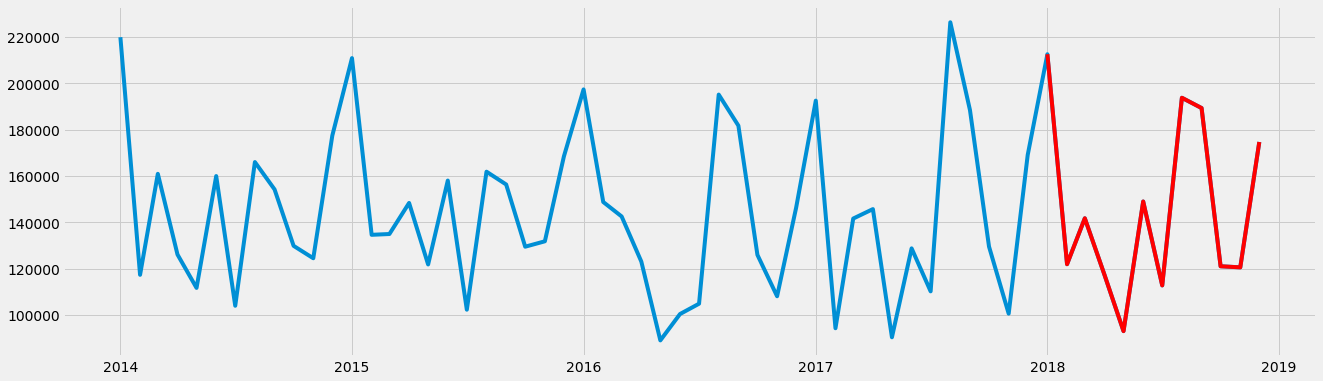

In [42]:
#构建训练集测试集
data=pd.Series(df.values[:,0],\
                             index=pd.DatetimeIndex(start='2014-01-01',end='2018-12-01',freq='MS'))
y=data[:48]
true=data[48:]
plt.figure(figsize=(20,6))  # 创建图形
plt.plot(data)
plt.plot(true,color='red')
plt.show()

In [43]:
#优化，找到最小的AIC 从而得到sarima模型的参数
'''
2-ARIMA Parameter Seletion
ARIMA(p,d,q)(P,D,Q)s
non-seasonal parameters: p,d,q
seasonal parameters: P,D,Q
'''
 
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
 
warnings.filterwarnings("ignore") # specify to ignore warning messages
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1252.9763187910366
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:267012.8007176619
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:799.372489071567
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:822.9831617341861
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:221794.58064327162
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:555.6924198755255
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1199.8565968654832
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:253248.96134376992
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:777.1805298407915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:928.68340625109
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5545725139.195413
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:556.2053981353106
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1119.3783878311838
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:20059.71478906995
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3453      0.271      1.275      0.202      -0.185       0.876
ma.L1         -0.8118      0.137     -5.938      0.000      -1.080      -0.544
ar.S.L12      -0.1724      0.231     -0.745      0.456      -0.626       0.281
sigma2      5.426e+08   3.75e-11   1.45e+19      0.000    5.43e+08    5.43e+08


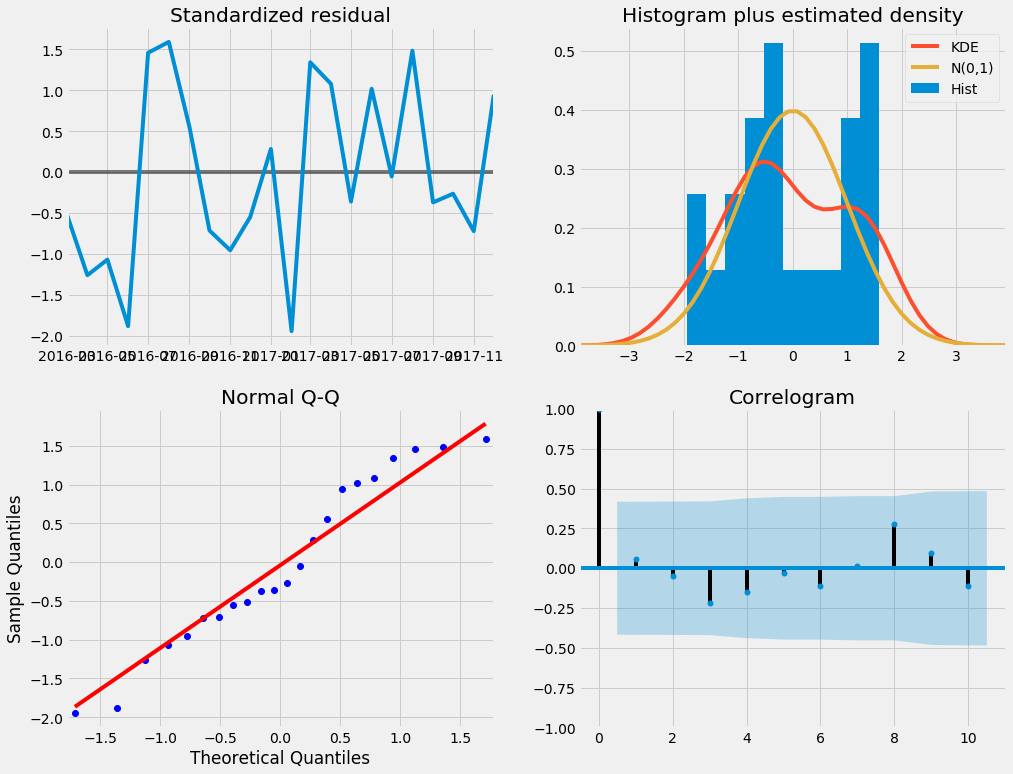

In [44]:
#检验模型
'''
3-Optimal Model Analysis
Use the best parameter combination to construct ARIMA model
Here we use ARIMA(1,1,1)(1,1,0)12 
the output coef represents the importance of each feature
Use plot_diagnostics() to check if parameters are against the model hypothesis
model residuals must not be correlated
'''
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

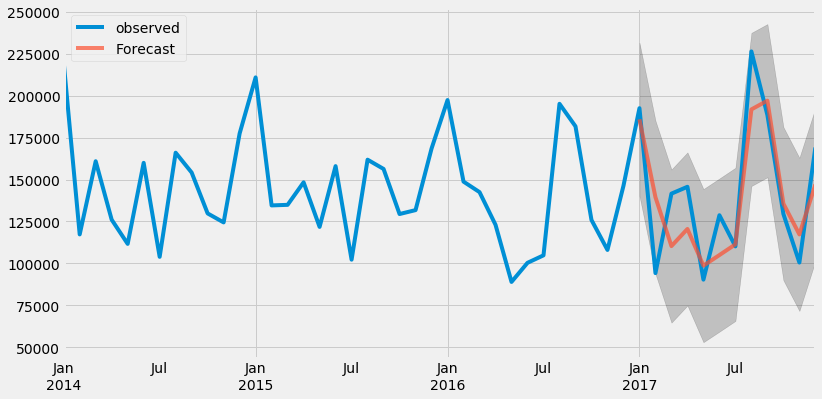

The Mean Squared Error of our forecasts is 23113.32
The MAPE of our forecasts is 14.5


In [60]:
#在训练集上进行预测
'''
4-Make Predictions
get_prediction(..., dynamic=False) 
Prediction of each point will use all historic observations prior to it 

'''
 
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int() # return the confidence interval of fitted parameters
 
# plot real values and predicted values
# pred.predicted_mean is a pandas series
ax = y['2014':].plot(label='observed', figsize=(12,6))  # ax is a matplotlib.axes.Axes
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

# fill_between(x,y,z) fills the area between two horizontal curves defined by (x,y)
# and (x,z). And alpha refers to the alpha transparencies 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('CO2 Levels')
plt.legend()
 
plt.show()
 
# Evaluation of model
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
 
# Compute the mean square error
rmse = (((y_forecasted - y_truth) ** 2).mean())**0.5
mape=np.mean(np.abs((y_forecasted - y_truth) / y_truth)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))

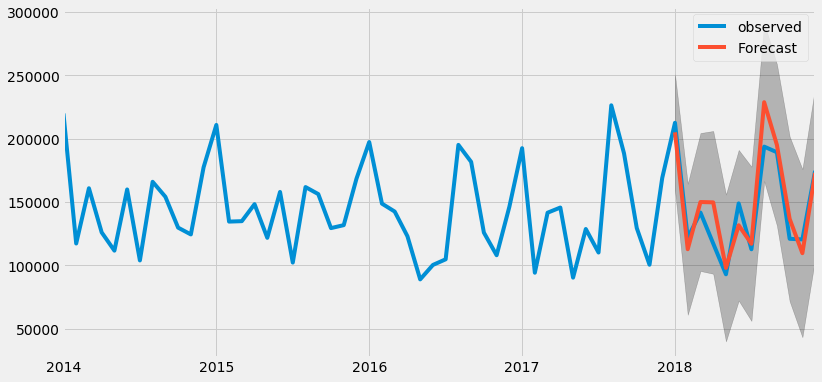

The Mean Squared Error of our forecasts is 16424.76
The MAPE of our forecasts is 9.13


In [63]:
#在测试集上进行预测
'''
6-Visualize Prediction
In-sample forecast: forecasting for an observation that was part of the data sample;
Out-of-sample forecast: forecasting for an observation that was not part of the data sample.
'''
 
# Get forecast 12 steps ahead in future
# 'steps': If an integer, the number of steps to forecast from the end of the sample.
pred_uc = results.get_forecast(steps=12)  # retun out-of-sample forecast 
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(12,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
#ax.set_xlabel('Date')
#ax.set_ylabel('CO2 Levels')
 
plt.legend()
plt.show()

# Compute the mean square error
y_forecasted=pred_uc.predicted_mean
rmse = (((y_forecasted - true) ** 2).mean())**0.5
mape=np.mean(np.abs((y_forecasted -  true) /  true)) * 100
print('The Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))
print('The MAPE of our forecasts is {}'.format(round(mape, 2)))